# 아파트 실거래가 예측

- Ref : https://dacon.io/competitions/official/21265/overview/
- Data Description : https://dacon.io/competitions/official/21265/data/
- Concept : 부동산 빅데이터와 AI를 이용하여 실거래가를 예측분석  
- 문제 개요 : 서울/부산 지역의 아파트 관련 정보를 바탕으로 실거래가를 예측  

- 참고 : 작성자의 주관으로 데이터를 분석한 것이므로 정답이 아닙니다. 

또한, 이 자료는 부산대 통계학과에서 수료한 [REN] "Real Data를 이용한 빅데이터 분석 및 머신러닝 A to Z" 특강을 참고하여 작성되었습니다.

In [1]:
import pandas as pd
import numpy as np


## train.csv 탐색 및 전처리
데이터가 커서 샘플링된 데이터 제공
해당 대회 같은 경우 스폰서 측 요청으로 대회 종료 후 데이터를 공개하지 못하게 됨
따라서 데이콘에서 국토부 실거래가 공공 데이터를 가공해서 대회와 최대한 유사하게 데이터를 재구성

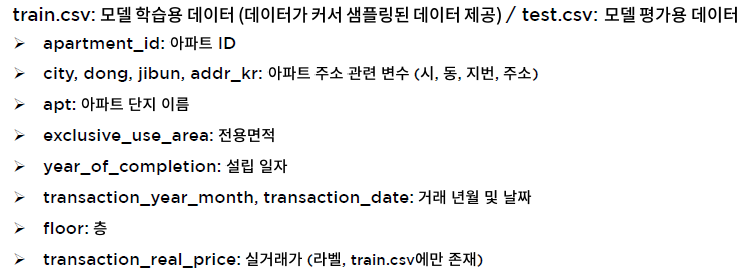

In [2]:
df=pd.read_csv("sampled_train.csv")
df.shape

(36016, 13)

In [3]:
df.head()

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
0,10923,1878,서울특별시,신당동,844,남산타운,신당동 844 남산타운,84.88,2002,201601,1~10,3,52000
1,10924,1878,서울특별시,신당동,844,남산타운,신당동 844 남산타운,84.88,2002,201601,1~10,10,58000
2,10927,1878,서울특별시,신당동,844,남산타운,신당동 844 남산타운,114.88,2002,201601,1~10,11,91500
3,10928,1878,서울특별시,신당동,844,남산타운,신당동 844 남산타운,114.88,2002,201601,11~20,13,72000
4,10930,1878,서울특별시,신당동,844,남산타운,신당동 844 남산타운,84.88,2002,201601,11~20,6,68300


### 구 변수 추가(아래 데이터는 직접 수집한 데이터, 어떠한 정제를 거치지 않음)
- day_care_center에는 동 정보가 없고, train, test 에는 구 정보가 없어 수집함
- 가지고 있는 데이터는 시와 동만 존재, 다른 데이터에 구만 있어서 병합이 어려울 것이 예상이 됨
- 활용할 만한 가치가 있다고 생각하는 변수는 활용하는 것도 good
- 따라서 가지고 있는 데이터에 구 변수를 부착해야함

1. 한국행정구연분류 데잍터 불러서 sheet, head 설정
2. 시와 동 기준으로 데이터 병합하는 방식으로 구 변수를 부착

#### 변수 부착시에 자주 발생하는 이슈 및 해결 방안(tip)
- 데이터에 있는 키의 상태 공간이 참조 데이터에 있는 키의 상태 공간에 완전히 포함되지 않아서, 병합했을 때 데이터 크기가 줄어드는 경우가 존재함
- 따라서 키 변수의 상태 공간이 겹치는 지를 **np.isin함수**를 사용하여 확인해야함

In [4]:
# 참조 데이터 불러오기
# 구글링해서 들고온 파일
# 엑셀 파일 내에서도 "법정동코드 연계 자료분석용" sheet 만 가지고 옴 
# 2번째 줄에 있는 자료들을 변수명으로 불러오기 위해 header=1 옵션을 사용
ref_df = pd.read_excel("한국행정구역분류.xlsx",
                       sheet_name = "법정동코드 연계 자료분석용",
                       header = 1)

ref_df.head()

,시도,시군구,행정구역명,행정동(행정기관명),법정동,행정구역코드,행정기관코드,행정기관 생성일,법정동코드,관할지역,행정동 영문명칭,비고
0,서울특별시,서울특별시,서울특별시,서울특별시,서울특별시,11.0,1100000000,19880423,1100000000,NaN,Seoul,NaN
1,서울특별시,종로구,종로구,종로구,종로구,11010.0,1111000000,19880423,1111000000,NaN,Jongno-gu,NaN
2,서울특별시,종로구,청운효자동,청운효자동,청운동,1101072.0,1111051500,20081101,1111010100,NaN,Cheongunhyoja-dong,NaN
3,서울특별시,종로구,청운효자동,청운효자동,신교동,1101072.0,1111051500,20081101,1111010200,NaN,Cheongunhyoja-dong,NaN
4,서울특별시,종로구,청운효자동,청운효자동,궁정동,1101072.0,1111051500,20081101,1111010300,NaN,Cheongunhyoja-dong,NaN


In [5]:
ref_df.tail()

,시도,시군구,행정구역명,행정동(행정기관명),법정동,행정구역코드,행정기관코드,행정기관 생성일,법정동코드,관할지역,행정동 영문명칭,비고
21662,제주특별자치도,서귀포시,중문동,중문동,대포동,3902061.0,5013061000,20060701,5013011400,NaN,Jungmun-dong,NaN
21663,제주특별자치도,서귀포시,중문동,중문동,하원동,3902061.0,5013061000,20060701,5013011800,NaN,Jungmun-dong,NaN
21664,제주특별자치도,서귀포시,예래동,예래동,색달동,3902062.0,5013062000,20060701,5013011900,NaN,Yerae-dong,NaN
21665,제주특별자치도,서귀포시,예래동,예래동,상예동,3902062.0,5013062000,20060701,5013012000,NaN,Yerae-dong,NaN
21666,제주특별자치도,서귀포시,예래동,예래동,하예동,3902062.0,5013062000,20060701,5013012100,NaN,Yerae-dong,NaN


In [6]:
# ref_df 필터링
# 서울, 부산 값만 가져옴
ref_df=ref_df[(ref_df['시도']=="서울특별시")|(ref_df['시도']=="부산광역시")]

In [7]:
# 필요한 변수만 추출
ref_df = ref_df[['시도', '시군구', '법정동']]
ref_df

,시도,시군구,법정동
0,서울특별시,서울특별시,서울특별시
1,서울특별시,종로구,종로구
2,서울특별시,종로구,청운동
3,서울특별시,종로구,신교동
4,서울특별시,종로구,궁정동
...,...,...,...
1133,부산광역시,기장군,구칠리
1134,부산광역시,기장군,이곡리
1135,부산광역시,기장군,고촌리
1136,부산광역시,기장군,안평리


In [8]:
# ref_df에 포함되어 있는 시도-읍면동과 df에 포함되어 있는 시도-읍면동이 일치하지 않는 경우를 확인해야 함
ref_df_loc = ref_df['시도'] + '-' + ref_df['법정동']
df_loc = (df['city'] + '-' + df['dong']).unique()
df_loc

array(['서울특별시-신당동', '서울특별시-행당동', '서울특별시-장안동', '서울특별시-신내동', '서울특별시-돈암동',
       '서울특별시-정릉동', '서울특별시-길음동', '서울특별시-하월곡동', '서울특별시-미아동', '서울특별시-방학동',
       '서울특별시-창동', '서울특별시-도봉동', '서울특별시-월계동', '서울특별시-공릉동', '서울특별시-상계동',
       '서울특별시-중계동', '서울특별시-신정동', '서울특별시-신월동', '서울특별시-화곡동', '서울특별시-가양동',
       '서울특별시-내발산동', '서울특별시-개봉동', '서울특별시-시흥동', '서울특별시-영등포동', '서울특별시-봉천동',
       '서울특별시-신림동', '서울특별시-반포동', '서울특별시-개포동', '서울특별시-대치동', '서울특별시-도곡동',
       '서울특별시-잠실동', '서울특별시-신천동', '서울특별시-가락동', '서울특별시-문정동', '서울특별시-명일동',
       '서울특별시-상일동', '서울특별시-암사동', '부산광역시-동삼동', '부산광역시-양정동', '부산광역시-부암동',
       '부산광역시-당감동', '부산광역시-개금동', '부산광역시-안락동', '부산광역시-사직동', '부산광역시-용호동',
       '부산광역시-금곡동', '부산광역시-화명동', '부산광역시-덕천동', '부산광역시-반여동', '부산광역시-재송동',
       '부산광역시-우동', '부산광역시-좌동', '부산광역시-하단동', '부산광역시-장림동', '부산광역시-다대동',
       '부산광역시-구서동', '부산광역시-명지동', '부산광역시-연산동', '부산광역시-남천동', '부산광역시-모라동',
       '부산광역시-정관읍 용수리'], dtype=object)

In [9]:
ref_df_loc.unique()

array(['서울특별시-서울특별시', '서울특별시-종로구', '서울특별시-청운동', '서울특별시-신교동', '서울특별시-궁정동',
       '서울특별시-효자동', '서울특별시-창성동', '서울특별시-통인동', '서울특별시-누상동', '서울특별시-누하동',
       '서울특별시-옥인동', '서울특별시-세종로', '서울특별시-통의동', '서울특별시-적선동', '서울특별시-체부동',
       '서울특별시-필운동', '서울특별시-내자동', '서울특별시-사직동', '서울특별시-도렴동', '서울특별시-당주동',
       '서울특별시-내수동', '서울특별시-신문로1가', '서울특별시-신문로2가', '서울특별시-팔판동',
       '서울특별시-삼청동', '서울특별시-안국동', '서울특별시-소격동', '서울특별시-화동', '서울특별시-사간동',
       '서울특별시-송현동', '서울특별시-부암동', '서울특별시-홍지동', '서울특별시-신영동', '서울특별시-구기동',
       '서울특별시-평창동', '서울특별시-무악동', '서울특별시-교남동', '서울특별시-평동', '서울특별시-송월동',
       '서울특별시-홍파동', '서울특별시-교북동', '서울특별시-행촌동', '서울특별시-가회동', '서울특별시-재동',
       '서울특별시-계동', '서울특별시-원서동', '서울특별시-청진동', '서울특별시-서린동', '서울특별시-수송동',
       '서울특별시-중학동', '서울특별시-종로1가', '서울특별시-공평동', '서울특별시-관훈동', '서울특별시-견지동',
       '서울특별시-와룡동', '서울특별시-권농동', '서울특별시-운니동', '서울특별시-익선동', '서울특별시-경운동',
       '서울특별시-관철동', '서울특별시-인사동', '서울특별시-낙원동', '서울특별시-종로2가', '서울특별시-훈정동',
       '서울특별시-묘동', '서울특별시-봉익동', '서울특별시-돈의동', '서울특별시-장사동', '서울특별시-관수동',
  

In [10]:
# df_loc에는 있으나 ref_df_loc에 포함되지 않는 경우가 있는지 확인
np.isin(df_loc, ref_df_loc)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False])

In [11]:
# 장안읍 예시: 
ref_df[ref_df['법정동'].str.contains('장안')]

,시도,시군구,법정동
275,서울특별시,동대문구,장안동
276,서울특별시,동대문구,장안동
1086,부산광역시,기장군,장안읍
1091,부산광역시,기장군,장안리


In [12]:
# 시도와 법정동이 완전히 똑같은 행이 있어, 이를 제거함(반드시 필요한 작업은 아님)
ref_df = ref_df.drop_duplicates(subset = ['시도', '법정동'])
ref_df.tail()

,시도,시군구,법정동
1133,부산광역시,기장군,구칠리
1134,부산광역시,기장군,이곡리
1135,부산광역시,기장군,고촌리
1136,부산광역시,기장군,안평리
1137,부산광역시,기장군,임기리


In [13]:
ref_df[ref_df['법정동'].str.contains('장안')]

,시도,시군구,법정동
275,서울특별시,동대문구,장안동
1086,부산광역시,기장군,장안읍
1091,부산광역시,기장군,장안리


#### 결론 : df의 dong에 리가 붙어있으면 제거해야함

In [14]:
df['dong'].str.split(' ', expand = True)

,0,1
0,신당동,None
1,신당동,None
2,신당동,None
3,신당동,None
4,신당동,None
...,...,...
36011,정관읍,용수리
36012,정관읍,용수리
36013,정관읍,용수리
36014,정관읍,용수리


In [15]:
df['dong'] = df['dong'].str.split(' ', expand = True).iloc[:, 0]
df['dong']

0        신당동
1        신당동
2        신당동
3        신당동
4        신당동
        ... 
36011    정관읍
36012    정관읍
36013    정관읍
36014    정관읍
36015    정관읍
Name: dong, Length: 36016, dtype: object

In [16]:
df_loc = (df['city'] + '-' + df['dong']).unique()
df_loc

array(['서울특별시-신당동', '서울특별시-행당동', '서울특별시-장안동', '서울특별시-신내동', '서울특별시-돈암동',
       '서울특별시-정릉동', '서울특별시-길음동', '서울특별시-하월곡동', '서울특별시-미아동', '서울특별시-방학동',
       '서울특별시-창동', '서울특별시-도봉동', '서울특별시-월계동', '서울특별시-공릉동', '서울특별시-상계동',
       '서울특별시-중계동', '서울특별시-신정동', '서울특별시-신월동', '서울특별시-화곡동', '서울특별시-가양동',
       '서울특별시-내발산동', '서울특별시-개봉동', '서울특별시-시흥동', '서울특별시-영등포동', '서울특별시-봉천동',
       '서울특별시-신림동', '서울특별시-반포동', '서울특별시-개포동', '서울특별시-대치동', '서울특별시-도곡동',
       '서울특별시-잠실동', '서울특별시-신천동', '서울특별시-가락동', '서울특별시-문정동', '서울특별시-명일동',
       '서울특별시-상일동', '서울특별시-암사동', '부산광역시-동삼동', '부산광역시-양정동', '부산광역시-부암동',
       '부산광역시-당감동', '부산광역시-개금동', '부산광역시-안락동', '부산광역시-사직동', '부산광역시-용호동',
       '부산광역시-금곡동', '부산광역시-화명동', '부산광역시-덕천동', '부산광역시-반여동', '부산광역시-재송동',
       '부산광역시-우동', '부산광역시-좌동', '부산광역시-하단동', '부산광역시-장림동', '부산광역시-다대동',
       '부산광역시-구서동', '부산광역시-명지동', '부산광역시-연산동', '부산광역시-남천동', '부산광역시-모라동',
       '부산광역시-정관읍'], dtype=object)

In [17]:
np.isin(df_loc, ref_df_loc)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

#### df와 ref_df 병합

In [18]:
# df와 ref_df 병합
df = pd.merge(df, ref_df, left_on = ['city', 'dong'], right_on = ['시도', '법정동'])
df.head()

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,시도,시군구,법정동
0,10923,1878,서울특별시,신당동,844,남산타운,신당동 844 남산타운,84.88,2002,201601,1~10,3,52000,서울특별시,중구,신당동
1,10924,1878,서울특별시,신당동,844,남산타운,신당동 844 남산타운,84.88,2002,201601,1~10,10,58000,서울특별시,중구,신당동
2,10927,1878,서울특별시,신당동,844,남산타운,신당동 844 남산타운,114.88,2002,201601,1~10,11,91500,서울특별시,중구,신당동
3,10928,1878,서울특별시,신당동,844,남산타운,신당동 844 남산타운,114.88,2002,201601,11~20,13,72000,서울특별시,중구,신당동
4,10930,1878,서울특별시,신당동,844,남산타운,신당동 844 남산타운,84.88,2002,201601,11~20,6,68300,서울특별시,중구,신당동


In [19]:
# ref_df에 있던 불필요한 변수 제거(right parts)
df.drop(['시도', '법정동'], axis = 1, inplace = True)
df.tail()

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,시군구
36011,1234627,9587,부산광역시,정관읍,1403,정관신도시한진해모로,정관읍 용수리 1403 정관신도시한진해모로,109.3076,2008,201709,21~30,2,33900,기장군
36012,1234712,9587,부산광역시,정관읍,1403,정관신도시한진해모로,정관읍 용수리 1403 정관신도시한진해모로,135.6199,2008,201710,11~20,10,40000,기장군
36013,1234715,9587,부산광역시,정관읍,1403,정관신도시한진해모로,정관읍 용수리 1403 정관신도시한진해모로,109.3076,2008,201710,11~20,12,36500,기장군
36014,1234717,9587,부산광역시,정관읍,1403,정관신도시한진해모로,정관읍 용수리 1403 정관신도시한진해모로,135.6199,2008,201710,11~20,13,41500,기장군
36015,1234822,9587,부산광역시,정관읍,1403,정관신도시한진해모로,정관읍 용수리 1403 정관신도시한진해모로,109.3076,2008,201711,11~20,5,36000,기장군


### 불필요한 변수 제거
- 사용하지 않는 변수인 transaction_id,addr_kr 변수는 미리 삭제하여, 메모리 부담을 줄인다.
- 모델에 직접 사용되지 않는 다른 변수(apartment_id 등)는 조건부 통계를 사용해 부착할 예정

In [20]:
df.drop(['transaction_id', 'addr_kr'], axis = 1, inplace = True) # transaction_id는 인덱스와 동일하므로 삭제해도 무방

In [21]:
# apartment_id는 id지만 어느정도 사용이 가능할 것이라 보임 (완전히 유니크하지 않으므로)
print(df['apartment_id'].value_counts().head(10))

print(df['apartment_id'].nunique()) # 유니크하지 않고, 무언가 일반적인 아이디 개념이 아닌 것으로 이해

10939    1031
703       947
4080      685
9436      656
4018      632
8031      601
729       595
2944      590
6467      570
12432     526
Name: apartment_id, dtype: int64
100


### 변수변환
- 아파트가 건축된지 얼마나 되었는지를 나타내는 변수 age를 생성
- transaction_year_month 변수에서, 거래 연도 추출

In [22]:
# 건축된지 얼마나 되었는지를 나타내는 변수로 변환
df['age'] = 2018 - df['year_of_completion']
df.drop('year_of_completion', axis = 1, inplace = True)


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36016 entries, 0 to 36015
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   apartment_id            36016 non-null  int64  
 1   city                    36016 non-null  object 
 2   dong                    36016 non-null  object 
 3   jibun                   36016 non-null  object 
 4   apt                     36016 non-null  object 
 5   exclusive_use_area      36016 non-null  float64
 6   transaction_year_month  36016 non-null  int64  
 7   transaction_date        36016 non-null  object 
 8   floor                   36016 non-null  int64  
 9   transaction_real_price  36016 non-null  int64  
 10  시군구                     36016 non-null  object 
 11  age                     36016 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 3.6+ MB


In [24]:
df['transaction_year_month']

0        201601
1        201601
2        201601
3        201601
4        201601
          ...  
36011    201709
36012    201710
36013    201710
36014    201710
36015    201711
Name: transaction_year_month, Length: 36016, dtype: int64

In [25]:
# transaction_year_month을 100으로 나눴을 때 몫은 거래 연도
# transaction_year_month을 100으로 나눴을 때 나머지는 거래 월
df['transaction_year']=df['transaction_year_month']//100
df['transaction_month']=df['transaction_year_month']%100
df.drop('transaction_year_month', axis = 1, inplace = True)

In [26]:
# 도시가 둘 뿐이므로 서울특별시인지 나타내는 이진 변수 생성
# seoul이 더 비쌀 것이다. 
df['Seoul'] = (df['city'] == "서울특별시").astype(int)

In [27]:
df

,apartment_id,city,dong,jibun,apt,exclusive_use_area,transaction_date,floor,transaction_real_price,시군구,age,transaction_year,transaction_month,Seoul
0,1878,서울특별시,신당동,844,남산타운,84.8800,1~10,3,52000,중구,16,2016,1,1
1,1878,서울특별시,신당동,844,남산타운,84.8800,1~10,10,58000,중구,16,2016,1,1
2,1878,서울특별시,신당동,844,남산타운,114.8800,1~10,11,91500,중구,16,2016,1,1
3,1878,서울특별시,신당동,844,남산타운,114.8800,11~20,13,72000,중구,16,2016,1,1
4,1878,서울특별시,신당동,844,남산타운,84.8800,11~20,6,68300,중구,16,2016,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36011,9587,부산광역시,정관읍,1403,정관신도시한진해모로,109.3076,21~30,2,33900,기장군,10,2017,9,0
36012,9587,부산광역시,정관읍,1403,정관신도시한진해모로,135.6199,11~20,10,40000,기장군,10,2017,10,0
36013,9587,부산광역시,정관읍,1403,정관신도시한진해모로,109.3076,11~20,12,36500,기장군,10,2017,10,0
36014,9587,부산광역시,정관읍,1403,정관신도시한진해모로,135.6199,11~20,13,41500,기장군,10,2017,10,0


In [28]:
df

,apartment_id,city,dong,jibun,apt,exclusive_use_area,transaction_date,floor,transaction_real_price,시군구,age,transaction_year,transaction_month,Seoul
0,1878,서울특별시,신당동,844,남산타운,84.8800,1~10,3,52000,중구,16,2016,1,1
1,1878,서울특별시,신당동,844,남산타운,84.8800,1~10,10,58000,중구,16,2016,1,1
2,1878,서울특별시,신당동,844,남산타운,114.8800,1~10,11,91500,중구,16,2016,1,1
3,1878,서울특별시,신당동,844,남산타운,114.8800,11~20,13,72000,중구,16,2016,1,1
4,1878,서울특별시,신당동,844,남산타운,84.8800,11~20,6,68300,중구,16,2016,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36011,9587,부산광역시,정관읍,1403,정관신도시한진해모로,109.3076,21~30,2,33900,기장군,10,2017,9,0
36012,9587,부산광역시,정관읍,1403,정관신도시한진해모로,135.6199,11~20,10,40000,기장군,10,2017,10,0
36013,9587,부산광역시,정관읍,1403,정관신도시한진해모로,109.3076,11~20,12,36500,기장군,10,2017,10,0
36014,9587,부산광역시,정관읍,1403,정관신도시한진해모로,135.6199,11~20,13,41500,기장군,10,2017,10,0


### 변수 구간화 : floor 변수
- 아파트의 층을 나타내는 floor변수는 이론적으로는 정수 형태의 연속형 변수이지만, 범주형 변수로 분리해준다.
- reasonable 하게 group화를 실시
- 층에 따른 실거래가 평균을 나타내는 그래프를 통해 그룹 기준을 확인가능
- 상세한 검증을 원하면 one-way-anova(일원분산분석)을 실시하는 것도 하나의 방법


In [29]:
# matplotlib  setting
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (16, 6)

<AxesSubplot:xlabel='floor'>

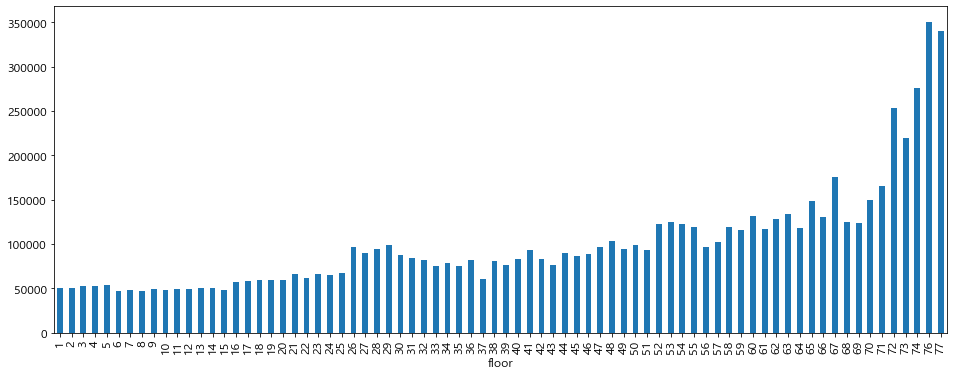

In [30]:
# 대략적인 구간 확인: 1층 이하, 1 ~ 25층, 26층 ~ 49층, 50층 이상
df.groupby(['floor'])['transaction_real_price'].mean().plot(kind = 'bar')

In [31]:
# 층의 수준을 생성한 뒤, 차이를 봄
df['floor_level']=(df['floor']>15).astype(int)+(df['floor']>25).astype(int)+(df['floor']>51).astype(int)+(df['floor']>71)

In [32]:
df.floor_level.value_counts()

0    28189
1     6531
2     1202
3       82
4       12
Name: floor_level, dtype: int64

<AxesSubplot:xlabel='floor_level'>

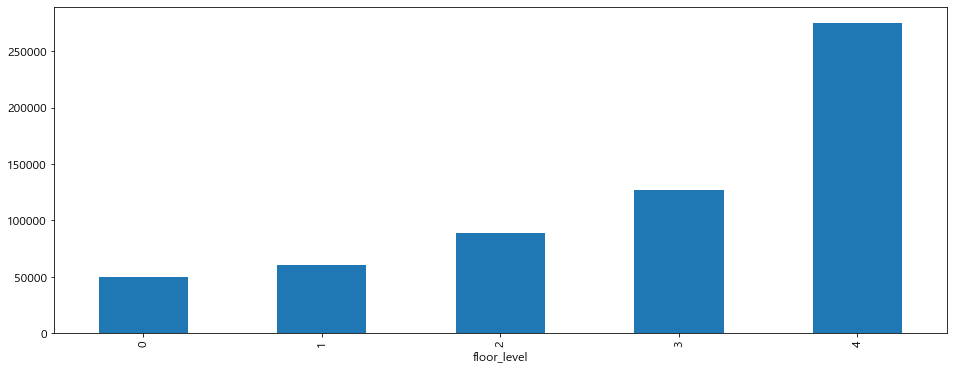

In [33]:
df.groupby(['floor_level'])['transaction_real_price'].mean().plot(kind = 'bar')

#### 확실히 그룹에 따라서 차이를 보임을  확인할 수 있다

#### floor_level 변수를 사용하기로 하고 floor 변수는 제거한다

In [34]:
df.drop('floor', axis = 1, inplace = True)

### 시세 변수 추가
- groupby를 이용해 city 변수와 시군구 변수에 따른 transaction_real_price의 평균을 구한 뒤, 이를 데이터에 부착하는 방식으로 **'구별_전체_평균_시세'** 변수를 추가함
- city, 시군구, transaction_year에 따른 transaction_real_price 평균과 개수(count)를 구하여, 이를 데이터에 부착하는 방식으로 **'구별_작년_평균_시세'**와 **'구별_작년_거래량 변수'**를 추가함
- apartment_id에 따른 transaction_real_price의 평균을 구한 뒤, 이를 데이터에 부착하는 방식으로 **'아파트별_평균가격 변수'**를 추가함

In [35]:
# 구별 전체 평균 시세 부착
# groupby 기준 변수가 '시군구'만 아닌 'city'를 넣은 이유는 서울특별시, 부산광역시에 똑같은 시군구가 운이 나쁘면 있을 수 있기 때문에
# as_index=False를 설정해주어 group의 기준이 되는 변수가 index가 되지 않도록 만들어준다
mean_price_per_gu = df.groupby(['city', '시군구'], as_index = False)['transaction_real_price'].mean() 
mean_price_per_gu.rename({'transaction_real_price':'구별_전체_평균_시세'}, axis = 1, inplace = True)
df = pd.merge(df, mean_price_per_gu, on = ['city', '시군구']) 
df.tail()

,apartment_id,city,dong,jibun,apt,exclusive_use_area,transaction_date,transaction_real_price,시군구,age,transaction_year,transaction_month,Seoul,floor_level,구별_전체_평균_시세
36011,9587,부산광역시,정관읍,1403,정관신도시한진해모로,109.3076,21~30,33900,기장군,10,2017,9,0,0,35605.185185
36012,9587,부산광역시,정관읍,1403,정관신도시한진해모로,135.6199,11~20,40000,기장군,10,2017,10,0,0,35605.185185
36013,9587,부산광역시,정관읍,1403,정관신도시한진해모로,109.3076,11~20,36500,기장군,10,2017,10,0,0,35605.185185
36014,9587,부산광역시,정관읍,1403,정관신도시한진해모로,135.6199,11~20,41500,기장군,10,2017,10,0,0,35605.185185
36015,9587,부산광역시,정관읍,1403,정관신도시한진해모로,109.3076,11~20,36000,기장군,10,2017,11,0,0,35605.185185


In [36]:
# 구별 작년 시세 부착
# price_per_gu_and_year 변수에 직접 수정을 하므로, df가 변경되는 것을 방지하기 위해, df.copy().groupby~를 사용
price_per_gu_and_year = df.copy().groupby(['city', '시군구', 'transaction_year'], as_index = False)['transaction_real_price'].agg(['mean', 'count'])
price_per_gu_and_year = price_per_gu_and_year.reset_index().rename({"mean":"구별_작년_평균_시세", "count":"구별_작년_거래량"}, axis = 1)
price_per_gu_and_year['transaction_year'] += 1 # 작년것을 붙이기 위해, 1을 더함
price_per_gu_and_year

,city,시군구,transaction_year,구별_작년_평균_시세,구별_작년_거래량
0,부산광역시,강서구,2017,44207.446735,291
1,부산광역시,강서구,2018,48796.506944,144
2,부산광역시,금정구,2017,44675.108225,231
3,부산광역시,금정구,2018,51055.434783,138
4,부산광역시,기장군,2017,34756.122449,98
...,...,...,...,...,...
59,서울특별시,영등포구,2018,52934.065934,182
60,서울특별시,중구,2017,60128.461538,260
61,서울특별시,중구,2018,64166.273585,212
62,서울특별시,중랑구,2017,26105.000000,164


In [37]:
# 작년 기록이 없어서 붙지 않는 것을 방지하기 위해, how = 'left'로 설정
df = pd.merge(df, price_per_gu_and_year, on = ['city', '시군구', 'transaction_year'], how = 'left') 
df.tail()

,apartment_id,city,dong,jibun,apt,exclusive_use_area,transaction_date,transaction_real_price,시군구,age,transaction_year,transaction_month,Seoul,floor_level,구별_전체_평균_시세,구별_작년_평균_시세,구별_작년_거래량
36011,9587,부산광역시,정관읍,1403,정관신도시한진해모로,109.3076,21~30,33900,기장군,10,2017,9,0,0,35605.185185,34756.122449,98.0
36012,9587,부산광역시,정관읍,1403,정관신도시한진해모로,135.6199,11~20,40000,기장군,10,2017,10,0,0,35605.185185,34756.122449,98.0
36013,9587,부산광역시,정관읍,1403,정관신도시한진해모로,109.3076,11~20,36500,기장군,10,2017,10,0,0,35605.185185,34756.122449,98.0
36014,9587,부산광역시,정관읍,1403,정관신도시한진해모로,135.6199,11~20,41500,기장군,10,2017,10,0,0,35605.185185,34756.122449,98.0
36015,9587,부산광역시,정관읍,1403,정관신도시한진해모로,109.3076,11~20,36000,기장군,10,2017,11,0,0,35605.185185,34756.122449,98.0


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36016 entries, 0 to 36015
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   apartment_id            36016 non-null  int64  
 1   city                    36016 non-null  object 
 2   dong                    36016 non-null  object 
 3   jibun                   36016 non-null  object 
 4   apt                     36016 non-null  object 
 5   exclusive_use_area      36016 non-null  float64
 6   transaction_date        36016 non-null  object 
 7   transaction_real_price  36016 non-null  int64  
 8   시군구                     36016 non-null  object 
 9   age                     36016 non-null  int64  
 10  transaction_year        36016 non-null  int64  
 11  transaction_month       36016 non-null  int64  
 12  Seoul                   36016 non-null  int32  
 13  floor_level             36016 non-null  int32  
 14  구별_전체_평균_시세             36016 non-null

In [39]:
df.describe()

,apartment_id,exclusive_use_area,transaction_real_price,age,transaction_year,transaction_month,Seoul,floor_level,구별_전체_평균_시세,구별_작년_평균_시세,구별_작년_거래량
count,36016.000000,36016.000000,36016.000000,36016.000000,36016.000000,36016.000000,36016.000000,36016.000000,36016.000000,15333.000000,15333.000000
mean,6342.721901,76.681158,53211.849900,20.150516,2016.425727,6.400627,0.662594,0.256247,53211.849900,51762.608580,1294.835714
std,3750.286430,31.098774,39164.697175,9.072141,0.494460,2.885411,0.472831,0.524404,34210.771417,32533.260332,871.793956
min,421.000000,27.680000,5000.000000,6.000000,2016.000000,1.000000,0.000000,0.000000,10556.666667,10319.387755,98.000000
25%,2944.000000,55.020000,26400.000000,12.000000,2016.000000,4.000000,0.000000,0.000000,28268.691020,26803.591754,555.000000
50%,6467.000000,74.205600,42000.000000,18.000000,2016.000000,6.000000,1.000000,0.000000,45071.787440,43615.933413,1086.000000
75%,9807.000000,84.974800,65000.000000,28.000000,2017.000000,9.000000,1.000000,0.000000,55912.064954,60128.461538,2474.000000
max,12569.000000,244.972000,379840.000000,40.000000,2017.000000,12.000000,1.000000,4.000000,195882.758621,186530.275229,2635.000000


In [40]:
# 구별 작년 거래 데이터가 없다는 것은, 구별 작년 거래량이 0이라는 이야기이므로 fillna(0)을 수행
df['구별_작년_거래량'].fillna(0, inplace = True) 


In [41]:
# 아파트별 평균 시세 부착
price_per_aid = df.copy().groupby(['apartment_id'], as_index = False)['transaction_real_price'].mean()
price_per_aid.rename({"transaction_real_price":"아파트별_평균가격"}, axis = 1, inplace = True)
price_per_aid

,apartment_id,아파트별_평균가격
0,421,48584.101382
1,459,22526.850575
2,520,56564.027149
3,532,21795.052265
4,549,28001.929012
...,...,...
95,11957,26470.000000
96,12015,45210.779661
97,12432,53907.298479
98,12454,26159.109589


In [42]:
df = pd.merge(df, price_per_aid, on = ['apartment_id'])
df.tail()

,apartment_id,city,dong,jibun,apt,exclusive_use_area,transaction_date,transaction_real_price,시군구,age,transaction_year,transaction_month,Seoul,floor_level,구별_전체_평균_시세,구별_작년_평균_시세,구별_작년_거래량,아파트별_평균가격
36011,9587,부산광역시,정관읍,1403,정관신도시한진해모로,109.3076,21~30,33900,기장군,10,2017,9,0,0,35605.185185,34756.122449,98.0,35605.185185
36012,9587,부산광역시,정관읍,1403,정관신도시한진해모로,135.6199,11~20,40000,기장군,10,2017,10,0,0,35605.185185,34756.122449,98.0,35605.185185
36013,9587,부산광역시,정관읍,1403,정관신도시한진해모로,109.3076,11~20,36500,기장군,10,2017,10,0,0,35605.185185,34756.122449,98.0,35605.185185
36014,9587,부산광역시,정관읍,1403,정관신도시한진해모로,135.6199,11~20,41500,기장군,10,2017,10,0,0,35605.185185,34756.122449,98.0,35605.185185
36015,9587,부산광역시,정관읍,1403,정관신도시한진해모로,109.3076,11~20,36000,기장군,10,2017,11,0,0,35605.185185,34756.122449,98.0,35605.185185


## 외부 데이터 부착

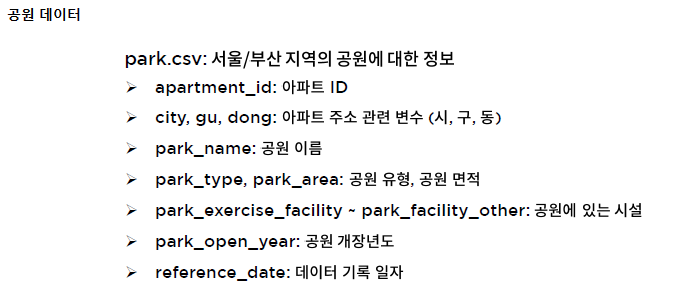

In [43]:
park_df = pd.read_csv("park.csv")
park_df.head()

,city,gu,dong,park_name,park_type,park_area,park_exercise_facility,park_entertainment_facility,park_benefit_facility,park_cultural_facitiy,park_facility_other,park_open_year,reference_date
0,부산광역시,남구,대연동,대연공원,근린공원,55227.0,NaN,NaN,NaN,NaN,NaN,1944.0,2018-08-14
1,부산광역시,남구,대연동,당곡공원,역사공원,75465.0,NaN,NaN,NaN,NaN,NaN,1944.0,2018-08-14
2,부산광역시,남구,대연동,대일어린이공원,어린이공원,422.1,NaN,NaN,NaN,NaN,NaN,1965.0,2018-08-14
3,부산광역시,남구,대연동,못골어린이공원,어린이공원,499.8,NaN,NaN,NaN,NaN,NaN,1968.0,2018-08-14
4,부산광역시,남구,용호동,솔밭어린이공원,어린이공원,1500.2,NaN,NaN,NaN,NaN,NaN,1970.0,2018-08-14


In [44]:
park_df.park_exercise_facility.value_counts()

0                                16
3                                12
5                                10
체력단련기구                            9
체력단련시설 4기                         9
                                 ..
체력단련시설 8기                         1
농구대 외 1종 2점                       1
운동장 1개소, 배드민턴 2개소, 체력단력시설 14점     1
"테니스장,배드민턴장,체력단련시설"               1
체력단련시설 1개소                        1
Name: park_exercise_facility, Length: 124, dtype: int64

In [45]:
print(park_df['park_exercise_facility'].nunique())
print(park_df['park_exercise_facility'].unique()[0:20])

124
[nan '게이트볼장' '풋살운동장' '배드민턴장' '야외헬스형운동기구 1개' '"축구장,배드민턴장"' '"배드민턴장,테니스장"'
 '"다목적운동장,농구장,배드민턴장"' '다목적운동장' '"배드민턴장, 게이트볼장"' '"테니스장,배드민턴장,체력단련시설"'
 'x-game장' '"축구장, 게이트볼장, 테니스장"' '5' '3' '7' '12' '10조12종' '0' '5조9종']


- 'park_exercise_facility'는 너무 다양한 종류의 값이 존재 
- 결측치도 존재
- 따라서 해당변수를 더미화(one-hot)하기에는 무리가 있음
- 해당 변수가 결측인지 아닌지만 나타내는 변수로 변환
-  'park_entertainment_facility', 'park_benefit_facility', 'park_cultural_facitiy', 'park_facility_other' 변수들 역시 같은 방법으로 전처리

In [46]:
park_df['park_exercise_facility'].isnull()

0       True
1       True
2       True
3       True
4       True
        ... 
1354    True
1355    True
1356    True
1357    True
1358    True
Name: park_exercise_facility, Length: 1359, dtype: bool

In [47]:
1-park_df['park_exercise_facility'].isnull()

0       0
1       0
2       0
3       0
4       0
       ..
1354    0
1355    0
1356    0
1357    0
1358    0
Name: park_exercise_facility, Length: 1359, dtype: int32

In [48]:
park_df['park_exercise_facility']=1-park_df['park_exercise_facility'].isnull()
park_df['park_entertainment_facility']=1-park_df['park_entertainment_facility'].isnull()
park_df['park_cultural_facitiy']=1-park_df['park_cultural_facitiy'].isnull()
park_df['park_benefit_facility']=1-park_df['park_benefit_facility'].isnull()
park_df['park_facility_other']=1-park_df['park_facility_other'].isnull()

In [49]:
park_df.tail()

,city,gu,dong,park_name,park_type,park_area,park_exercise_facility,park_entertainment_facility,park_benefit_facility,park_cultural_facitiy,park_facility_other,park_open_year,reference_date
1354,서울특별시,구로구,천왕동,이펜시아어린이공원,어린이공원,1500.0,0,1,0,0,0,2006.0,2019-02-25
1355,서울특별시,구로구,천왕동,개명소공원,소공원,5415.0,0,0,0,0,0,2006.0,2019-02-25
1356,서울특별시,구로구,천왕동,봉화대근린공원,근린공원,60975.0,0,0,0,0,0,2006.0,2019-02-25
1357,서울특별시,구로구,항동,푸른수목원,근린공원,100809.0,0,0,0,0,0,2005.0,2019-02-25
1358,서울특별시,구로구,오류동,오류동역문화공원,문화공원,7510.0,0,0,0,0,0,2013.0,2019-02-25


### 동별로 유형에 따른 공원 수를 계산한 뒤, 데이터에 부착함

In [50]:
# 동별 공원 수 
num_park_per_dong = park_df.groupby(['city', 'gu', 'dong'], as_index = False)['park_name'].count()
num_park_per_dong.rename({"park_name":"공원수"}, axis = 1, inplace = True)

In [51]:
# 동별 공원에 배치된 facilty 수
facility_cols = ['park_exercise_facility', 'park_entertainment_facility', 'park_benefit_facility', 'park_cultural_facitiy', 'park_facility_other']
# groupby를 이용해서 시설이 있는 공원의 수를 count한다
num_facilty_per_dong = park_df.groupby(['city', 'gu', 'dong'], as_index = False)[facility_cols].sum()
num_facilty_per_dong.head()

,city,gu,dong,park_exercise_facility,park_entertainment_facility,park_benefit_facility,park_cultural_facitiy,park_facility_other
0,부산광역시,강서구,녹산동,1,0,1,0,1
1,부산광역시,강서구,대저1동,1,0,0,0,1
2,부산광역시,강서구,명지동,13,17,4,0,25
3,부산광역시,강서구,송정동,2,0,2,0,2
4,부산광역시,강서구,신호동,2,3,1,0,3


In [52]:
# 공원 데이터 부착
df = pd.merge(df, num_park_per_dong, left_on = ['city', '시군구', 'dong'], right_on = ['city', 'gu', 'dong'], how = 'left')
df['공원수'].fillna(0, inplace = True)
df.drop('gu', axis = 1, inplace = True)

In [53]:
# 시설이 있는 공원의 수 부착
df = pd.merge(df, num_facilty_per_dong, left_on = ['city', '시군구', 'dong'], right_on = ['city', 'gu', 'dong'], how = 'left')
df.drop('gu', axis = 1, inplace = True)

In [54]:
df

,apartment_id,city,dong,jibun,apt,exclusive_use_area,transaction_date,transaction_real_price,시군구,age,...,구별_전체_평균_시세,구별_작년_평균_시세,구별_작년_거래량,아파트별_평균가격,공원수,park_exercise_facility,park_entertainment_facility,park_benefit_facility,park_cultural_facitiy,park_facility_other
0,1878,서울특별시,신당동,844,남산타운,84.8800,1~10,52000,중구,16,...,61942.055085,NaN,0.0,61942.055085,3.0,1.0,2.0,1.0,0.0,0.0
1,1878,서울특별시,신당동,844,남산타운,84.8800,1~10,58000,중구,16,...,61942.055085,NaN,0.0,61942.055085,3.0,1.0,2.0,1.0,0.0,0.0
2,1878,서울특별시,신당동,844,남산타운,114.8800,1~10,91500,중구,16,...,61942.055085,NaN,0.0,61942.055085,3.0,1.0,2.0,1.0,0.0,0.0
3,1878,서울특별시,신당동,844,남산타운,114.8800,11~20,72000,중구,16,...,61942.055085,NaN,0.0,61942.055085,3.0,1.0,2.0,1.0,0.0,0.0
4,1878,서울특별시,신당동,844,남산타운,84.8800,11~20,68300,중구,16,...,61942.055085,NaN,0.0,61942.055085,3.0,1.0,2.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36011,9587,부산광역시,정관읍,1403,정관신도시한진해모로,109.3076,21~30,33900,기장군,10,...,35605.185185,34756.122449,98.0,35605.185185,0.0,NaN,NaN,NaN,NaN,NaN
36012,9587,부산광역시,정관읍,1403,정관신도시한진해모로,135.6199,11~20,40000,기장군,10,...,35605.185185,34756.122449,98.0,35605.185185,0.0,NaN,NaN,NaN,NaN,NaN
36013,9587,부산광역시,정관읍,1403,정관신도시한진해모로,109.3076,11~20,36500,기장군,10,...,35605.185185,34756.122449,98.0,35605.185185,0.0,NaN,NaN,NaN,NaN,NaN
36014,9587,부산광역시,정관읍,1403,정관신도시한진해모로,135.6199,11~20,41500,기장군,10,...,35605.185185,34756.122449,98.0,35605.185185,0.0,NaN,NaN,NaN,NaN,NaN


In [55]:
df['park_exercise_facility'].fillna(0,inplace=True)
df['park_entertainment_facility'].fillna(0,inplace=True)
df['park_benefit_facility'].fillna(0,inplace=True)
df['park_cultural_facitiy'].fillna(0,inplace=True)
df['park_facility_other'].fillna(0,inplace=True)

In [56]:
df

,apartment_id,city,dong,jibun,apt,exclusive_use_area,transaction_date,transaction_real_price,시군구,age,...,구별_전체_평균_시세,구별_작년_평균_시세,구별_작년_거래량,아파트별_평균가격,공원수,park_exercise_facility,park_entertainment_facility,park_benefit_facility,park_cultural_facitiy,park_facility_other
0,1878,서울특별시,신당동,844,남산타운,84.8800,1~10,52000,중구,16,...,61942.055085,NaN,0.0,61942.055085,3.0,1.0,2.0,1.0,0.0,0.0
1,1878,서울특별시,신당동,844,남산타운,84.8800,1~10,58000,중구,16,...,61942.055085,NaN,0.0,61942.055085,3.0,1.0,2.0,1.0,0.0,0.0
2,1878,서울특별시,신당동,844,남산타운,114.8800,1~10,91500,중구,16,...,61942.055085,NaN,0.0,61942.055085,3.0,1.0,2.0,1.0,0.0,0.0
3,1878,서울특별시,신당동,844,남산타운,114.8800,11~20,72000,중구,16,...,61942.055085,NaN,0.0,61942.055085,3.0,1.0,2.0,1.0,0.0,0.0
4,1878,서울특별시,신당동,844,남산타운,84.8800,11~20,68300,중구,16,...,61942.055085,NaN,0.0,61942.055085,3.0,1.0,2.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36011,9587,부산광역시,정관읍,1403,정관신도시한진해모로,109.3076,21~30,33900,기장군,10,...,35605.185185,34756.122449,98.0,35605.185185,0.0,0.0,0.0,0.0,0.0,0.0
36012,9587,부산광역시,정관읍,1403,정관신도시한진해모로,135.6199,11~20,40000,기장군,10,...,35605.185185,34756.122449,98.0,35605.185185,0.0,0.0,0.0,0.0,0.0,0.0
36013,9587,부산광역시,정관읍,1403,정관신도시한진해모로,109.3076,11~20,36500,기장군,10,...,35605.185185,34756.122449,98.0,35605.185185,0.0,0.0,0.0,0.0,0.0,0.0
36014,9587,부산광역시,정관읍,1403,정관신도시한진해모로,135.6199,11~20,41500,기장군,10,...,35605.185185,34756.122449,98.0,35605.185185,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36016 entries, 0 to 36015
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   apartment_id                 36016 non-null  int64  
 1   city                         36016 non-null  object 
 2   dong                         36016 non-null  object 
 3   jibun                        36016 non-null  object 
 4   apt                          36016 non-null  object 
 5   exclusive_use_area           36016 non-null  float64
 6   transaction_date             36016 non-null  object 
 7   transaction_real_price       36016 non-null  int64  
 8   시군구                          36016 non-null  object 
 9   age                          36016 non-null  int64  
 10  transaction_year             36016 non-null  int64  
 11  transaction_month            36016 non-null  int64  
 12  Seoul                        36016 non-null  int32  
 13  floor_level     

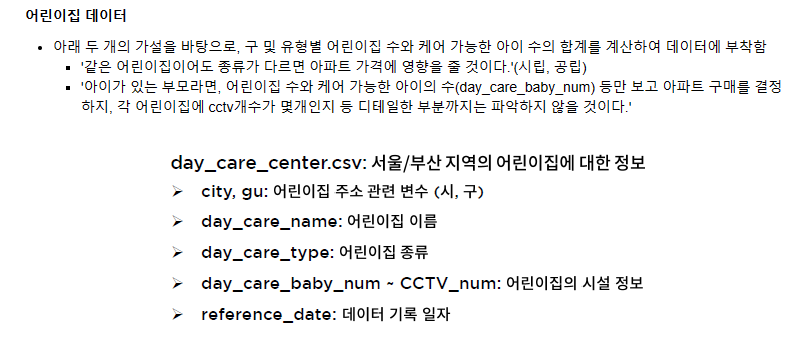

In [58]:
day_care_center_df = pd.read_csv('day_care_center.csv')
day_care_center_df.head()

,city,gu,day_care_name,day_care_type,day_care_baby_num,teacher_num,nursing_room_num,playground_num,CCTV_num,is_commuting_vehicle,reference_date
0,서울특별시,서대문구,가람어린이집,국공립,70,11.0,5.0,1.0,7.0,N,2018-07-31
1,서울특별시,서대문구,가좌제일어린이집,국공립,88,22.0,5.0,2.0,10.0,N,2018-07-31
2,서울특별시,서대문구,경찰청어린이집,직장,90,23.0,6.0,1.0,32.0,N,2018-07-31
3,서울특별시,서대문구,고운햇살어린이집,가정,18,5.0,3.0,0.0,4.0,N,2018-07-31
4,서울특별시,서대문구,고은어린이집,국공립,93,20.0,7.0,2.0,10.0,N,2018-07-31


### 구 및 유형별 어린이집 수와 케어 가능한 아이 수만 집계

In [59]:
# 불필요한 변수 제거
day_care_center_df = day_care_center_df[['city', 'gu', 'day_care_type', 'day_care_baby_num']]

#### day_care_type 변수의 전처리

In [60]:
day_care_center_df['day_care_type'].unique()

array(['국공립', '직장', '가정', '민간', '법인·단체', '협동', '사회복지법인'], dtype=object)

In [61]:
# 더미화 해준다 ( 원-핫 인코딩 )
dummy_day_care_type = pd.get_dummies(day_care_center_df['day_care_type'], drop_first = False)
dummy_day_care_type

,가정,국공립,민간,법인·단체,사회복지법인,직장,협동
0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
7546,0,0,1,0,0,0,0
7547,1,0,0,0,0,0,0
7548,0,0,1,0,0,0,0
7549,0,0,1,0,0,0,0


In [62]:
# 변수명 변경
dummy_day_care_type = dummy_day_care_type.add_prefix("어린이집유형_")
dummy_day_care_type

,어린이집유형_가정,어린이집유형_국공립,어린이집유형_민간,어린이집유형_법인·단체,어린이집유형_사회복지법인,어린이집유형_직장,어린이집유형_협동
0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
7546,0,0,1,0,0,0,0
7547,1,0,0,0,0,0,0
7548,0,0,1,0,0,0,0
7549,0,0,1,0,0,0,0


In [63]:
# 데이터 부착
day_care_center_df = pd.concat([day_care_center_df, dummy_day_care_type], axis = 1)
day_care_center_df.drop('day_care_type', axis = 1, inplace = True)
day_care_center_df.head()

,city,gu,day_care_baby_num,어린이집유형_가정,어린이집유형_국공립,어린이집유형_민간,어린이집유형_법인·단체,어린이집유형_사회복지법인,어린이집유형_직장,어린이집유형_협동
0,서울특별시,서대문구,70,0,1,0,0,0,0,0
1,서울특별시,서대문구,88,0,1,0,0,0,0,0
2,서울특별시,서대문구,90,0,0,0,0,0,1,0
3,서울특별시,서대문구,18,1,0,0,0,0,0,0
4,서울특별시,서대문구,93,0,1,0,0,0,0,0


#### day_care_center 데이터에 "동" 정보는 존재하지 않으므로 'city','gu'를 기준으로 groupby를 해준다

In [64]:
aggregated_day_care_center_df = day_care_center_df.groupby(['city', 'gu'], as_index = False)[day_care_center_df.columns[2:]].sum()
aggregated_day_care_center_df.head()

,city,gu,day_care_baby_num,어린이집유형_가정,어린이집유형_국공립,어린이집유형_민간,어린이집유형_법인·단체,어린이집유형_사회복지법인,어린이집유형_직장,어린이집유형_협동
0,부산광역시,강서구,5312,71.0,6.0,35.0,0.0,5.0,5.0,1.0
1,부산광역시,금정구,5251,30.0,6.0,58.0,1.0,7.0,3.0,1.0
2,부산광역시,기장군,7689,98.0,13.0,56.0,0.0,5.0,3.0,3.0
3,부산광역시,남구,6676,65.0,12.0,50.0,2.0,6.0,6.0,2.0
4,부산광역시,동구,2214,8.0,9.0,11.0,2.0,2.0,7.0,0.0


In [65]:
# 어린이집 데이터 부착
df = pd.merge(df, aggregated_day_care_center_df, left_on = ['city', '시군구'], right_on = ['city', 'gu'], how = 'left')


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36016 entries, 0 to 36015
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   apartment_id                 36016 non-null  int64  
 1   city                         36016 non-null  object 
 2   dong                         36016 non-null  object 
 3   jibun                        36016 non-null  object 
 4   apt                          36016 non-null  object 
 5   exclusive_use_area           36016 non-null  float64
 6   transaction_date             36016 non-null  object 
 7   transaction_real_price       36016 non-null  int64  
 8   시군구                          36016 non-null  object 
 9   age                          36016 non-null  int64  
 10  transaction_year             36016 non-null  int64  
 11  transaction_month            36016 non-null  int64  
 12  Seoul                        36016 non-null  int32  
 13  floor_level     

#### 어린이집 데이터의 NA값 처리


In [67]:
aggregated_day_care_center_df.columns

Index(['city', 'gu', 'day_care_baby_num', '어린이집유형_가정', '어린이집유형_국공립',
       '어린이집유형_민간', '어린이집유형_법인·단체', '어린이집유형_사회복지법인', '어린이집유형_직장', '어린이집유형_협동'],
      dtype='object')

In [68]:
for col in aggregated_day_care_center_df.columns:
    df[col]=df[col].fillna(0)

In [69]:
# 겹치는 "gu" 변수 제거
df.drop('gu', axis = 1, inplace = True)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36016 entries, 0 to 36015
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   apartment_id                 36016 non-null  int64  
 1   city                         36016 non-null  object 
 2   dong                         36016 non-null  object 
 3   jibun                        36016 non-null  object 
 4   apt                          36016 non-null  object 
 5   exclusive_use_area           36016 non-null  float64
 6   transaction_date             36016 non-null  object 
 7   transaction_real_price       36016 non-null  int64  
 8   시군구                          36016 non-null  object 
 9   age                          36016 non-null  int64  
 10  transaction_year             36016 non-null  int64  
 11  transaction_month            36016 non-null  int64  
 12  Seoul                        36016 non-null  int32  
 13  floor_level     

## 모델 피팅을 위한 전처리

- 라벨 변수 Y에는 transaction_real_price를 할당 
- 변수에는 라벨을 포함하여 불필요한 변수를 제거하여 정의
- 결측치 조정

In [71]:
X = df.drop(['apartment_id', 'city', 'dong', 'jibun', 'apt', 'transaction_date', 'transaction_real_price', '시군구', 'transaction_year', 'transaction_month'], axis = 1)
y = df['transaction_real_price']

In [72]:
X['floor_level'].value_counts()

0    28189
1     6531
2     1202
3       82
4       12
Name: floor_level, dtype: int64

### 더미화
- Feature가 많지 않고, 범주형 변수의 개수도 많지 않아 dummy화 하더라도 큰 문제는 없을 것으로 예상
- floor_level 변수에 대한 더미화를 수행

In [73]:
# 더미화
# Onehot-encoder 나 get_dummies를 이용하면 데이터를 나누고 다시 부착해주는 과정이 필요하기에 직접 변수를 생성한다
X['floor_1']=(X['floor_level']==1).astype(int)
X['floor_2']=(X['floor_level']==2).astype(int)
X['floor_3']=(X['floor_level']==3).astype(int)
X['floor_4']=(X['floor_level']==4).astype(int)

# 더미화 했으니 floor_level 변수는 삭제한다
X.drop('floor_level', axis = 1, inplace = True)
X

,exclusive_use_area,age,Seoul,구별_전체_평균_시세,구별_작년_평균_시세,구별_작년_거래량,아파트별_평균가격,공원수,park_exercise_facility,park_entertainment_facility,...,어린이집유형_국공립,어린이집유형_민간,어린이집유형_법인·단체,어린이집유형_사회복지법인,어린이집유형_직장,어린이집유형_협동,floor_1,floor_2,floor_3,floor_4
0,84.8800,16,1,61942.055085,NaN,0.0,61942.055085,3.0,1.0,2.0,...,23.0,7.0,7.0,0.0,18.0,0.0,0,0,0,0
1,84.8800,16,1,61942.055085,NaN,0.0,61942.055085,3.0,1.0,2.0,...,23.0,7.0,7.0,0.0,18.0,0.0,0,0,0,0
2,114.8800,16,1,61942.055085,NaN,0.0,61942.055085,3.0,1.0,2.0,...,23.0,7.0,7.0,0.0,18.0,0.0,0,0,0,0
3,114.8800,16,1,61942.055085,NaN,0.0,61942.055085,3.0,1.0,2.0,...,23.0,7.0,7.0,0.0,18.0,0.0,0,0,0,0
4,84.8800,16,1,61942.055085,NaN,0.0,61942.055085,3.0,1.0,2.0,...,23.0,7.0,7.0,0.0,18.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36011,109.3076,10,0,35605.185185,34756.122449,98.0,35605.185185,0.0,0.0,0.0,...,13.0,56.0,0.0,5.0,3.0,3.0,0,0,0,0
36012,135.6199,10,0,35605.185185,34756.122449,98.0,35605.185185,0.0,0.0,0.0,...,13.0,56.0,0.0,5.0,3.0,3.0,0,0,0,0
36013,109.3076,10,0,35605.185185,34756.122449,98.0,35605.185185,0.0,0.0,0.0,...,13.0,56.0,0.0,5.0,3.0,3.0,0,0,0,0
36014,135.6199,10,0,35605.185185,34756.122449,98.0,35605.185185,0.0,0.0,0.0,...,13.0,56.0,0.0,5.0,3.0,3.0,0,0,0,0


In [74]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36016 entries, 0 to 36015
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   exclusive_use_area           36016 non-null  float64
 1   age                          36016 non-null  int64  
 2   Seoul                        36016 non-null  int32  
 3   구별_전체_평균_시세                  36016 non-null  float64
 4   구별_작년_평균_시세                  15333 non-null  float64
 5   구별_작년_거래량                    36016 non-null  float64
 6   아파트별_평균가격                    36016 non-null  float64
 7   공원수                          36016 non-null  float64
 8   park_exercise_facility       36016 non-null  float64
 9   park_entertainment_facility  36016 non-null  float64
 10  park_benefit_facility        36016 non-null  float64
 11  park_cultural_facitiy        36016 non-null  float64
 12  park_facility_other          36016 non-null  float64
 13  day_care_baby_nu

### 결측치 대체 
- 구별_작년_평균_시세 변수에 결측치가 존재함을 알 수 있다. 
- 연속형 변수이고 결측값이 모델에 영향을 적게 주도록 하기위해서 평균값으로 결측치를 대체한다.

In [75]:
mean_last_year=X['구별_작년_평균_시세'].mean()
X['구별_작년_평균_시세']=X['구별_작년_평균_시세'].fillna(mean_last_year)

In [76]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36016 entries, 0 to 36015
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   exclusive_use_area           36016 non-null  float64
 1   age                          36016 non-null  int64  
 2   Seoul                        36016 non-null  int32  
 3   구별_전체_평균_시세                  36016 non-null  float64
 4   구별_작년_평균_시세                  36016 non-null  float64
 5   구별_작년_거래량                    36016 non-null  float64
 6   아파트별_평균가격                    36016 non-null  float64
 7   공원수                          36016 non-null  float64
 8   park_exercise_facility       36016 non-null  float64
 9   park_entertainment_facility  36016 non-null  float64
 10  park_benefit_facility        36016 non-null  float64
 11  park_cultural_facitiy        36016 non-null  float64
 12  park_facility_other          36016 non-null  float64
 13  day_care_baby_nu

In [77]:
train_X=X.copy()
train_y=y.copy()

## 모델 학습
- 다양한 모델을 적용하여 best 모델을 찾아낸다


In [78]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge

lr_model = LinearRegression()
rf_model = RandomForestRegressor()
lgb_model = LGBMRegressor()
ridge_model=Ridge()


In [79]:
# 하이퍼 파라미터 튜닝을 위한 객체
rf_params={
    'n_estimators':[20,50,100,200],
    'max_depth':[2,3,4,5,10]
    }

lgb_params={
    'n_estimators':[20,50,100,200],
    'max_depth':[2,3,4,5,10],
    'learning_rate':[0.05,0.1,0.15,0.2,0.25]
    }

ridge_params={'alpha':[0.1,1,3,5]}

In [80]:
grid_cv_rf=GridSearchCV(rf_model,param_grid=rf_params,cv=7,scoring="neg_mean_squared_error")
grid_cv_lgb=GridSearchCV(lgb_model,param_grid=lgb_params,cv=7,scoring="neg_mean_squared_error")
grid_cv_ridge=GridSearchCV(ridge_model,param_grid=ridge_params,cv=7,scoring="neg_mean_squared_error")

grid_cv_rf.fit(X,y)
grid_cv_lgb.fit(X,y)
grid_cv_ridge.fit(X,y)

print('rf Best params:',grid_cv_rf.best_params_)
print('lgb Best params:',grid_cv_lgb.best_params_)
print('ridge Best params:',grid_cv_ridge.best_params_)


rf Best params: {'max_depth': 10, 'n_estimators': 20}
lgb Best params: {'learning_rate': 0.25, 'max_depth': 4, 'n_estimators': 200}
ridge Best params: {'alpha': 0.1}


In [84]:
model_lr=LinearRegression()
model_ridge=Ridge(alpha = 0.1)
model_rf=RandomForestRegressor( max_depth=10,n_estimators=20)
model_lgb= LGBMRegressor(learning_rate=0.25,max_depth=4,n_estimators=200)

In [87]:
from sklearn.model_selection import cross_val_score

lr_neg_mse_scores = cross_val_score(model_lr, X, y, scoring="neg_mean_squared_error", cv = 5)
ridge_neg_mse_scores = cross_val_score(model_ridge, X, y, scoring="neg_mean_squared_error", cv = 5)
rf_neg_mse_scores = cross_val_score(model_rf, X, y, scoring="neg_mean_squared_error", cv = 5)
lgb_neg_mse_scores = cross_val_score(model_lgb, X, y, scoring="neg_mean_squared_error", cv = 5)


lr_rmse=np.sqrt(-1 * lr_neg_mse_scores)
ridge_rmse=np.sqrt(-1 * ridge_neg_mse_scores)
rf_rmse=np.sqrt(-1 * rf_neg_mse_scores)
lgb_rmse=np.sqrt(-1 * lgb_neg_mse_scores)


print("lr_rmse:\n",lr_rmse)
print("ridge_rmse:\n",ridge_rmse)
print("rf_rmse:\n",rf_rmse)
print("lgb_rmse:\n",lgb_rmse)

lr_rmse:
 [ 6883.88583542  6013.75966516 22315.44663433  8449.73405539
 49648.62927684]
ridge_rmse:
 [ 6884.47650951  6014.0847271  22312.6690431   8451.47708397
 49619.07214239]
rf_rmse:
 [ 5099.58764182  7762.59997964 46367.53812691  6303.39721462
 16827.08575457]
lgb_rmse:
 [ 4714.9924259   5165.5112538  44301.03072649  6453.21219634
 15536.88909299]


In [89]:
print("lr_평균_rmse :\n",round(lr_rmse.mean(),1))
print("ridge_평균_rmse :\n",round(ridge_rmse.mean(),1))
print("rf_평균_rmse :\n",round(rf_rmse.mean(),1))
print("lgb_평균_rmse :\n",round(lgb_rmse.mean(),1))

lr_평균_rmse :
 18662.3
ridge_평균_rmse :
 18656.4
rf_평균_rmse :
 16472.0
lgb_평균_rmse :
 15234.3


### 모델학습 결론
- cv의 rmse를 살펴봤을 때 선형 회귀와 , tree 회귀의 결과가 cv마다 다름을 볼 수 있다.
- 모델마다 잘 잡아내지 못한 특징이 있다고 해석할 수 있다.
- 잔차 분석 등 너무 깊은 지식을 요구하기에 평균 rmse를 기준으로 모델을 선정한다
- lgb 모델을 선정한다

In [98]:
best_model=model_lgb
best_model.fit(X,y)

LGBMRegressor(learning_rate=0.25, max_depth=4, n_estimators=200)

## test 데이터 전처리(파이프라인 구축)

- 새로운 데이터에 대한 예측을 수행하기 위해, 하나의 함수 형태로 파이프라인을 구축함

In [90]:
def pipline(new_data,ref_df):
    ################  변수 변환 및 부착   ################
    # dong 에 리 붙어있으면 제거
    new_data['dong'] = new_data['dong'].str.split(' ', expand = True).iloc[:, 0]
    
    # 시,구,군 부착
    new_data=pd.merge(new_data,ref_df,left_on=["city","dong"],right_on=['시도','법정동'])
    
    # 불필요한 변수 제거
    new_data.drop(['시도', '법정동', 'transaction_id', 'addr_kr'], axis = 1, inplace = True)
    
    # age변수 부착
    new_data['age']=2018-new_data['year_of_completion'] # 2018년 이후 수정 필요
    
    # 거래 년월 부착
    new_data['transaction_year']=new_data['transaction_year_month']//100
    new_data['transaction_month']=new_data['transaction_year_month']%100
    new_data.drop('transaction_year_month', axis = 1, inplace = True)   
    
    # Seoul 생성
    new_data['Seoul'] = (new_data['city'] == "서울특별시").astype(int) 
    
    # floor_level변수 생성
    new_data['floor_level']=(new_data['floor']>15).astype(int)+(new_data['floor']>25).astype(int)+(new_data['floor']>51).astype(int)+(new_data['floor']>71)
    new_data.drop('floor', axis = 1, inplace = True)  
    
    # 시세 관련 변수 추가
    new_data = pd.merge(new_data, mean_price_per_gu, on = ['city', '시군구'])
    new_data = pd.merge(new_data, price_per_gu_and_year, on = ['city', '시군구', 'transaction_year'], how = 'left')
    new_data['구별_작년_거래량'].fillna(0, inplace = True) # 구별 작년 거래 데이터가 없다는 것은, 구별 작년 거래량이 0이라는 이야기이므로 fillna(0)을 수행
           
    new_data = pd.merge(new_data, price_per_aid, on = ['apartment_id'], how = 'left') # 아파트 거래 시세 추가
    
    # 공원 데이터 부착
    new_data = pd.merge(new_data, num_park_per_dong, left_on = ['city', '시군구', 'dong'], right_on = ['city', 'gu', 'dong'], how = 'left')
    new_data['공원수'].fillna(0, inplace = True)
    new_data.drop('gu', axis = 1, inplace = True)
    
    new_data = pd.merge(new_data, num_facilty_per_dong, left_on = ['city', '시군구', 'dong'], right_on = ['city', 'gu', 'dong'], how = 'left')
    
    facility_cols = ['park_exercise_facility', 'park_entertainment_facility', 'park_benefit_facility', 'park_cultural_facitiy', 'park_facility_other']
    
    for col in facility_cols:                            #### 공원 데이터 결측치 처리
        new_data[col]=new_data[col].fillna(0)
    
    new_data.drop('gu', axis = 1, inplace = True)
    
    # 어린이집 데이터 부착
    new_data = pd.merge(new_data, aggregated_day_care_center_df, left_on = ['city', '시군구'], right_on = ['city', 'gu'], how = 'left')
    
    
    for col in aggregated_day_care_center_df.columns:    #### 어린이집 데이터 결측치 제거
        new_data[col]=new_data[col].fillna(0)
    
    new_data.drop('gu', axis = 1, inplace = True) # 변수제거
    
    ################   모델 학습을 위한 전처리 (더미화 & 결측치 제거)  ################
    
    # 더미화
    new_data['floor_1']=(new_data['floor_level']==1).astype(int)
    new_data['floor_2']=(new_data['floor_level']==2).astype(int)
    new_data['floor_3']=(new_data['floor_level']==3).astype(int)
    new_data['floor_4']=(new_data['floor_level']==4).astype(int)

    new_data.drop('floor_level', axis = 1, inplace = True) # 더미화 했으니 floor_level 변수는 삭제한다
    
    # 결측치 처리(작년 시세)
    new_data['구별_작년_평균_시세']=new_data['구별_작년_평균_시세'].fillna(mean_last_year)
    
    # train_X와 동일한 변수 추출
    test_X=new_data[train_X.columns]
    
    
    return test_X

In [92]:
test_data=pd.read_csv("sampled_test.csv")

In [93]:
test_data

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor
0,1197195,4018,서울특별시,암사동,414-2,롯데캐슬퍼스트,암사동 414-2 롯데캐슬퍼스트,102.340,2008,201712,21~31,9
1,1190777,520,서울특별시,가락동,140,가락(1차)쌍용아파트,가락동 140 가락(1차)쌍용아파트,59.920,1997,201712,21~31,15
2,1197165,6467,서울특별시,암사동,509,선사현대아파트,암사동 509 선사현대아파트,59.640,2000,201712,21~31,6
3,1179572,731,서울특별시,개포동,189,개포주공 4단지,개포동 189 개포주공 4단지,50.670,1982,201707,1~10,3
4,1131476,5950,서울특별시,상계동,626,상계주공14(고층),상계동 626 상계주공14(고층),90.940,1989,201712,11~20,6
...,...,...,...,...,...,...,...,...,...,...,...,...
384,1162728,8272,서울특별시,영등포동,647,영등포푸르지오,영등포동 647 영등포푸르지오,79.777,2002,201712,11~20,13
385,1214400,12432,부산광역시,화명동,2324,화명롯데캐슬카이저,화명동 2324 화명롯데캐슬카이저,115.030,2012,201712,11~20,30
386,1210776,8415,부산광역시,용호동,944,오륙도에스케이뷰,용호동 944 오륙도에스케이뷰,123.307,2008,201712,11~20,33
387,1190462,10909,서울특별시,잠실동,35,트리지움,잠실동 35 트리지움,114.700,2007,201712,21~31,18


In [94]:
test_X=pipline(new_data=test_data,ref_df=ref_df)

In [95]:
test_X

,exclusive_use_area,age,Seoul,구별_전체_평균_시세,구별_작년_평균_시세,구별_작년_거래량,아파트별_평균가격,공원수,park_exercise_facility,park_entertainment_facility,...,어린이집유형_국공립,어린이집유형_민간,어린이집유형_법인·단체,어린이집유형_사회복지법인,어린이집유형_직장,어린이집유형_협동,floor_1,floor_2,floor_3,floor_4
0,102.34,10,1,55912.064954,52527.178658,1237,68696.756329,1.0,0.0,0.0,...,62.0,99.0,2.0,1.0,5.0,0.0,0,0,0,0
1,59.64,18,1,55912.064954,52527.178658,1237,48961.578947,1.0,0.0,0.0,...,62.0,99.0,2.0,1.0,5.0,0.0,0,0,0,0
2,84.81,10,1,55912.064954,52527.178658,1237,68696.756329,1.0,0.0,0.0,...,62.0,99.0,2.0,1.0,5.0,0.0,0,0,0,0
3,111.22,10,1,55912.064954,52527.178658,1237,68696.756329,1.0,0.0,0.0,...,62.0,99.0,2.0,1.0,5.0,0.0,0,0,0,0
4,84.98,10,1,55912.064954,52527.178658,1237,68696.756329,1.0,0.0,0.0,...,62.0,99.0,2.0,1.0,5.0,0.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,81.05,11,1,48937.006579,47542.857143,147,48937.006579,13.0,2.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
385,112.92,11,1,48937.006579,47542.857143,147,48937.006579,13.0,2.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
386,114.84,14,1,34270.412371,33824.757282,206,34270.412371,3.0,2.0,2.0,...,50.0,49.0,10.0,1.0,7.0,1.0,1,0,0,0
387,59.94,17,1,45210.779661,43093.117647,170,45210.779661,6.0,5.0,5.0,...,65.0,91.0,8.0,3.0,9.0,6.0,0,0,0,0


In [97]:
test_X.columns==train_X.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [101]:
pred_y=pd.DataFrame(best_model.predict(test_X))

In [102]:
pred_y

,0
0,77132.767519
1,46206.531725
2,70465.520737
3,80397.124145
4,69125.491291
...,...
384,50291.114871
385,58888.354965
386,42383.040128
387,40541.054218
